In [ ]:
!pip install statsmodels==0.12.1

     |████████████████████████████████| 9.5 MB 14.8 MB/s 
     |████████████████████████████████| 231 kB 100.4 MB/s 
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn import linear_model
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

In [ ]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', -1)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [ ]:
# Upload merged census, weather, and covid inference dataset
raw_merged_data_path = "Data/Clean/census_weather_covid_inference.csv"

raw_inference_data = pd.read_csv(raw_merged_data_path, index_col= "Unnamed: 0").drop(columns = ["NAME", "FIPS"])

In [ ]:
raw_inference_data.mask(np.isclose(raw_inference_data.values,-999999999))

,income_med_dollars,insurance_perc,poverty_perc,pacific_perc,asian_perc,white_perc,black_perc,hispanic_perc,temp_mean,temp_range,temp_std,precip_mean,Incident_Rate
0,59049,94.1,9.8,0.1,3.0,71.3,22.4,5.9,17.075593,37.200000,8.716195,38.464407,6625.828000
1,82369,95.2,5.6,0.1,7.3,71.4,13.1,7.0,11.018305,47.600000,11.705671,23.867797,6815.458157
2,80096,94.7,2.7,0.3,6.3,83.4,6.2,5.2,9.478644,50.100000,11.613781,24.437288,5880.866494
3,59716,89.3,7.7,0.0,4.3,77.8,8.6,15.0,16.427458,39.400000,9.710894,20.267797,7639.494460
4,64871,96.3,6.6,0.0,3.9,79.4,12.9,2.3,13.485763,35.400000,9.153268,27.379661,4424.918486
5,57013,92.9,8.2,0.1,4.9,81.1,8.1,3.5,15.064407,42.300000,9.575212,34.447458,7400.963078
6,61618,77.6,12.1,0.1,7.0,61.4,19.1,43.7,23.701356,25.650000,6.033679,35.966102,5043.721789
7,61796,77.1,10.7,0.1,6.5,60.0,22.6,40.8,21.564576,31.900000,7.806620,33.655932,7335.110088
8,50845,86.9,12.7,0.0,1.4,79.8,13.7,27.0,21.550508,30.900000,7.639905,32.827119,7318.128149
9,55797,79.6,13.0,0.3,4.0,58.7,33.5,22.1,22.560000,22.300000,5.520927,38.240678,5408.542524


Now that we have our merged inference and prediction datasets uploaded, we to clean them up for modeling including:

1. Checking for missing data
2. Removing features with too few data points
3. Imputing missing data
4. Transforming feature distributions
5. Scaling distributions



First we start with the inference dataset which has 228 records and 13 features. 

In [ ]:
def countNaNs(df):
    """
    Returns a count of all NaNs for every column in the df.
    """
    nan_col_count = df.isna().sum()
    return nan_col_count

In [ ]:
countNaNs(raw_inference_data)

income_med_dollars    0
insurance_perc        0
poverty_perc          0
pacific_perc          0
asian_perc            0
white_perc            0
black_perc            0
hispanic_perc         0
temp_mean             0
temp_range            0
temp_std              0
precip_mean           0
Incident_Rate         0
dtype: int64

In [ ]:
raw_inference_data.describe()

,income_med_dollars,insurance_perc,poverty_perc,pacific_perc,asian_perc,white_perc,black_perc,hispanic_perc,temp_mean,temp_range,temp_std,precip_mean,Incident_Rate
count,228.000000,228.000000,228.000000,2.280000e+02,2.280000e+02,2.280000e+02,2.280000e+02,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000
mean,64262.456140,90.848246,8.830263,-2.631579e+07,-2.631579e+07,-2.631572e+07,-2.631578e+07,15.696491,15.009621,33.645701,7.855435,28.199840,6048.276285
std,16019.710747,4.819943,4.009648,1.604249e+08,1.604249e+08,1.604249e+08,1.604249e+08,15.597675,5.504902,8.320768,2.142942,16.209158,2621.612958
min,30480.000000,68.600000,0.900000,-1.000000e+09,-1.000000e+09,-1.000000e+09,-1.000000e+09,1.200000,3.130473,8.400000,1.424389,3.118644,201.955929
25%,54400.250000,88.600000,6.175000,0.000000e+00,1.300000e+00,6.527500e+01,1.600000e+00,5.575000,10.839098,28.715000,6.651398,16.282386,4488.484687
50%,60943.500000,92.050000,8.200000,5.000000e-02,2.700000e+00,7.890000e+01,6.600000e+00,10.200000,14.507804,34.100000,8.172870,27.447234,6034.762178
75%,72139.250000,94.200000,10.825000,2.000000e-01,4.700000e+00,8.662500e+01,1.387500e+01,19.900000,19.297605,38.525000,9.314800,37.981088,7389.783277
max,151800.000000,98.300000,28.900000,1.170000e+01,4.390000e+01,9.480000e+01,5.830000e+01,90.000000,27.316610,58.300000,13.563563,90.873786,14267.040345


At first it appears the data has no missing values, but looking at the summary stats of the data, there is an abundance of -99999999 values.

This is a number used to denote missing values. Since all of these values are floats, we use use numpy's *isclose()* function to replace these values with NaN. 

In [ ]:
def fillMissingWithNan(df):
    """
    Takes a dataframe and replaces all float values with -999999999 with NaN.
    """
    dfnan = df.mask(np.isclose(df.values,-999999999))
    return dfnan

In [ ]:
nan_inference_data = fillMissingWithNan(raw_inference_data)

In [ ]:
countNaNs(nan_inference_data)

income_med_dollars    0
insurance_perc        0
poverty_perc          0
pacific_perc          6
asian_perc            6
white_perc            6
black_perc            6
hispanic_perc         0
temp_mean             0
temp_range            0
temp_std              0
precip_mean           0
Incident_Rate         0
dtype: int64

In [ ]:
nan_inference_data[nan_inference_data["pacific_perc"].isna()]

,income_med_dollars,insurance_perc,poverty_perc,pacific_perc,asian_perc,white_perc,black_perc,hispanic_perc,temp_mean,temp_range,temp_std,precip_mean,Incident_Rate
10,55727,94.0,9.7,NaN,NaN,NaN,NaN,1.8,13.720408,45.7,10.026511,26.455782,9898.372431
30,80973,87.7,0.9,NaN,NaN,NaN,NaN,12.9,9.812500,34.3,8.684981,11.996622,6285.722194
66,39063,86.2,20.5,NaN,NaN,NaN,NaN,3.0,20.964286,27.9,6.098367,35.506803,6985.593548
126,56276,88.9,5.8,NaN,NaN,NaN,NaN,17.1,6.824281,33.6,8.288017,18.971338,9146.158982
189,46540,94.1,10.9,NaN,NaN,NaN,NaN,1.7,13.505424,34.7,8.054836,38.461017,3639.535993
219,49715,86.8,12.3,NaN,NaN,NaN,NaN,2.7,19.568814,32.3,7.370306,51.996610,8975.139286


There are 6 NaNs for all our our race columns (not including hispanic ehtnicity).

Since these 6 rows are all from the same record, they are not missing at random and imputation would be a poor method to try and utilize these records.

Instead we will remove them. 

In [ ]:
remove_missing_inference = nan_inference_data[~nan_inference_data["pacific_perc"].isna()]
remove_missing_inference

,income_med_dollars,insurance_perc,poverty_perc,pacific_perc,asian_perc,white_perc,black_perc,hispanic_perc,temp_mean,temp_range,temp_std,precip_mean,Incident_Rate
0,59049,94.1,9.8,0.1,3.0,71.3,22.4,5.9,17.075593,37.200000,8.716195,38.464407,6625.828000
1,82369,95.2,5.6,0.1,7.3,71.4,13.1,7.0,11.018305,47.600000,11.705671,23.867797,6815.458157
2,80096,94.7,2.7,0.3,6.3,83.4,6.2,5.2,9.478644,50.100000,11.613781,24.437288,5880.866494
3,59716,89.3,7.7,0.0,4.3,77.8,8.6,15.0,16.427458,39.400000,9.710894,20.267797,7639.494460
4,64871,96.3,6.6,0.0,3.9,79.4,12.9,2.3,13.485763,35.400000,9.153268,27.379661,4424.918486
5,57013,92.9,8.2,0.1,4.9,81.1,8.1,3.5,15.064407,42.300000,9.575212,34.447458,7400.963078
6,61618,77.6,12.1,0.1,7.0,61.4,19.1,43.7,23.701356,25.650000,6.033679,35.966102,5043.721789
7,61796,77.1,10.7,0.1,6.5,60.0,22.6,40.8,21.564576,31.900000,7.806620,33.655932,7335.110088
8,50845,86.9,12.7,0.0,1.4,79.8,13.7,27.0,21.550508,30.900000,7.639905,32.827119,7318.128149
9,55797,79.6,13.0,0.3,4.0,58.7,33.5,22.1,22.560000,22.300000,5.520927,38.240678,5408.542524


In [ ]:
countNaNs(remove_missing_inference)

income_med_dollars    0
insurance_perc        0
poverty_perc          0
pacific_perc          0
asian_perc            0
white_perc            0
black_perc            0
hispanic_perc         0
temp_mean             0
temp_range            0
temp_std              0
precip_mean           0
Incident_Rate         0
dtype: int64

Now that we have handled missing values (none are left), we can look at the distribution of the data.

In [ ]:
def plotAllDistributions(df, cols = False, save_fig = False):
    """
    Takes a dataframe, and plots the distribution of all columns.
    Optionally you can specify your columns of interest as an array.
    Returns either the figure, or saves it to a the Figures directory.
    """
    if cols:
        df = df.loc[:cols]

    fig = df.hist(layout = (4, -(-df.shape[1] // 4)), figsize = (20,20))
    
    if save_fig:
        figdir = os.path.join("Figures", save_fig)
        return plt.savefig(figdir)

    else:
        return fig


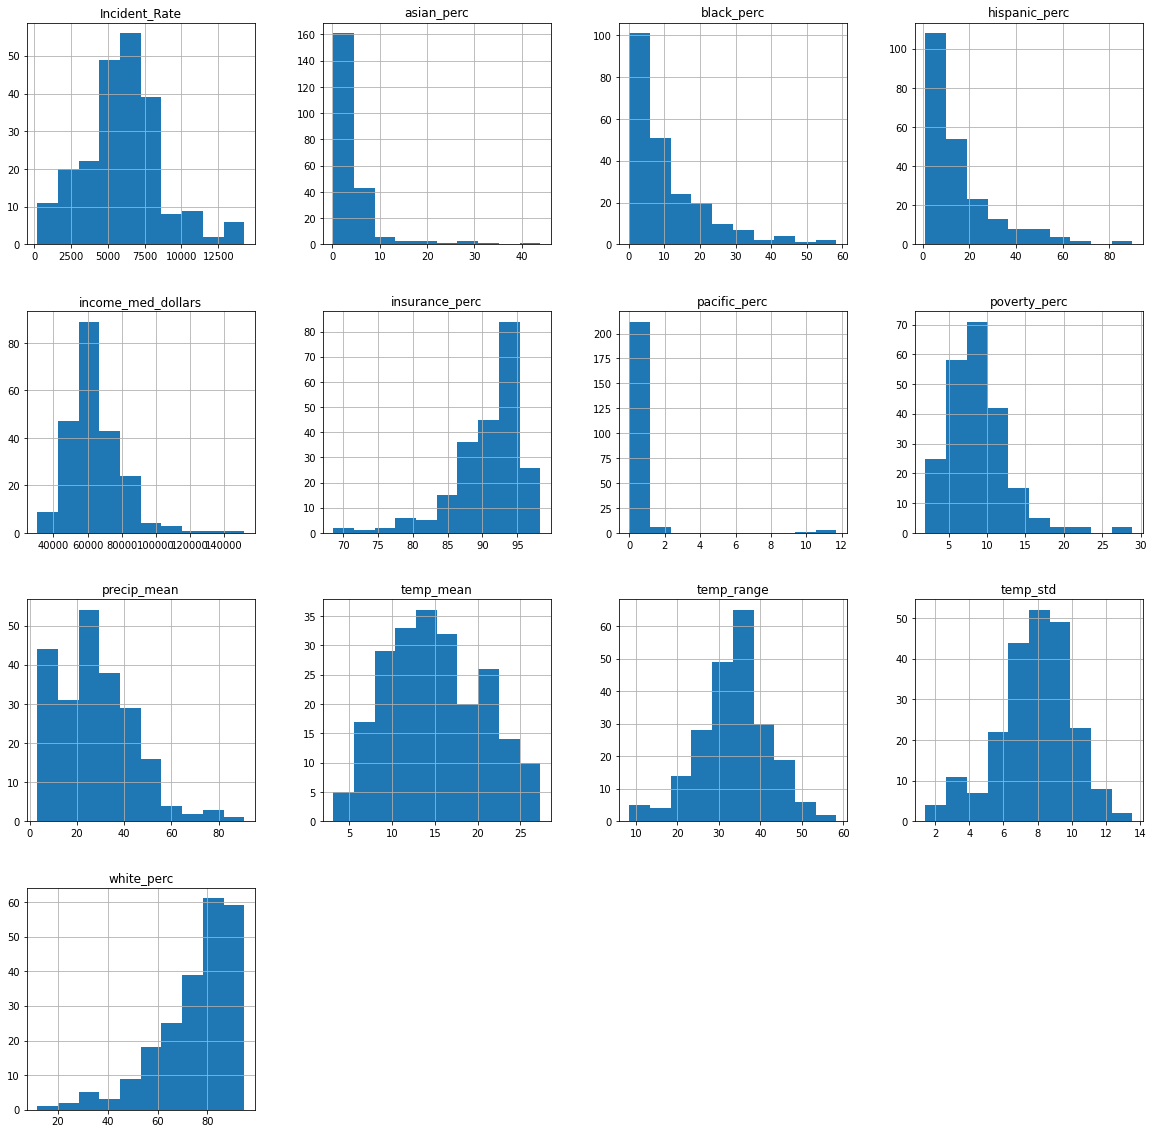

In [ ]:
plotAllDistributions(remove_missing_inference);

Some of the features look normally distributed including:

1. Temperature mean
2. Temperature range
3. Temperature standard deviation

Most of the feature do not have normal distributions including:

1. Income
2. Percent insured
3. Percent in poverty
4. All race and ethnicity columns



In [ ]:
def inference_transform(df):
    transdf = df.copy()

    transdf["income_med_dollars"] = np.log10(transdf["income_med_dollars"]+1)
    transdf["insurance_perc"] = transdf["insurance_perc"]**2
    transdf["poverty_perc"] = transdf["poverty_perc"]**(1/3)
    transdf["white_perc"] = transdf["white_perc"]**3
    transdf["black_perc"] = np.log10(transdf["black_perc"]+1)
    transdf["asian_perc"] = np.log10(transdf["asian_perc"]+1)
    transdf["pacific_perc"] = np.log10(transdf["pacific_perc"]+1)
    transdf["hispanic_perc"] = np.log10(transdf["hispanic_perc"]+1)
    transdf["precip_mean"] = transdf["precip_mean"]**(1/3)
    transdf["Incident_Rate"] = transdf["Incident_Rate"]#**(1/2)

    return transdf

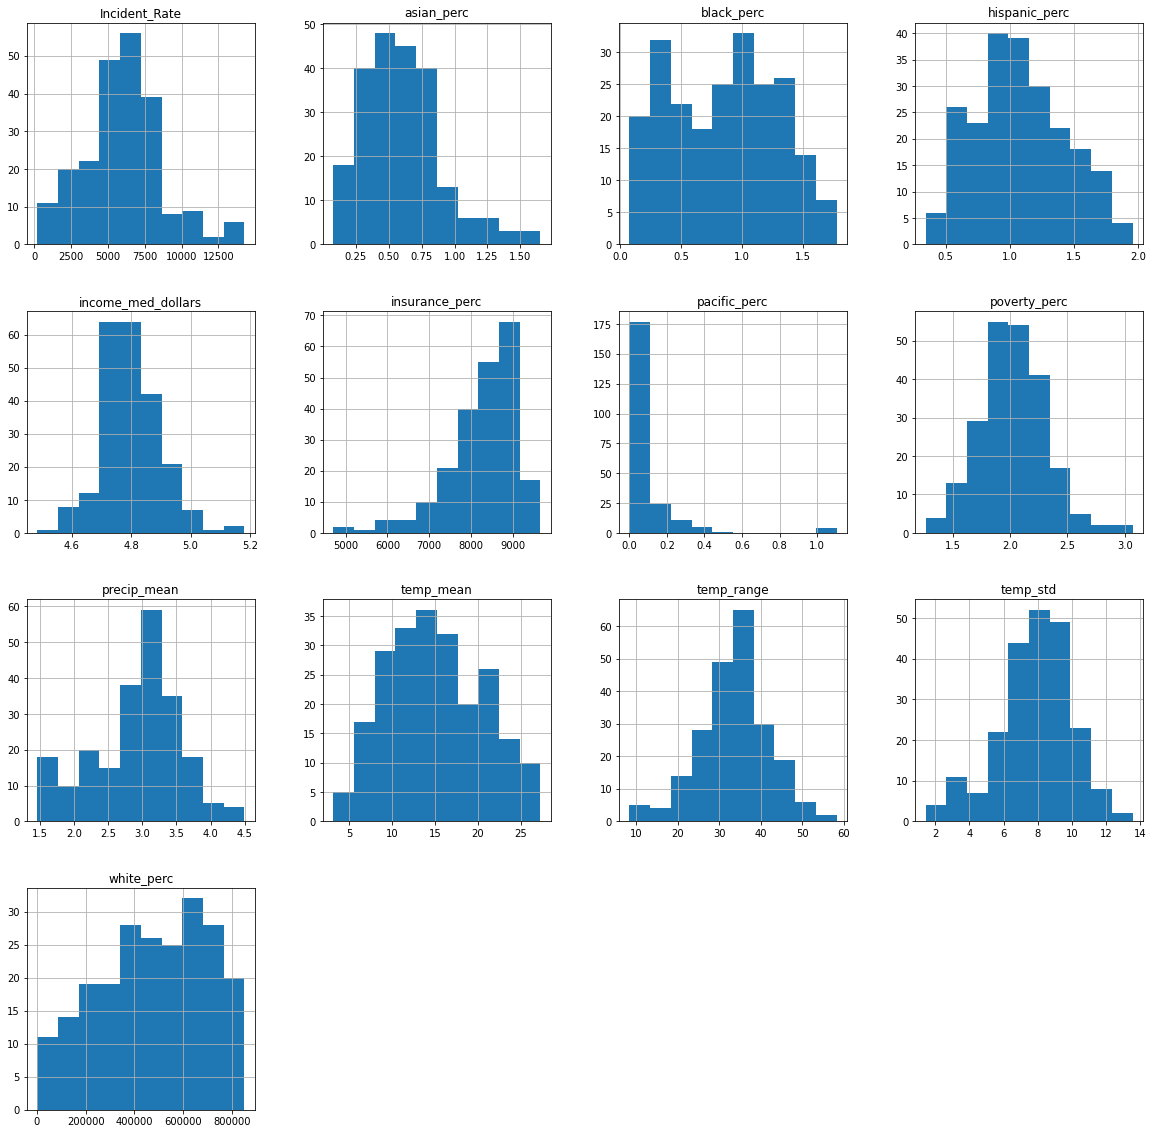

In [ ]:
transformed_inference = inference_transform(remove_missing_inference)
plotAllDistributions(transformed_inference);

In [ ]:
def normalTestAllFeatures(df, alpha = 0.05):
    """
    Takes a dataframe and performs the Shapiro-Wilk test of normality.
    Returns a dataframe summary including if the test is normal, and the p-value.
    
    A p-value <= alpha indicates that the feature rejects the null hypothesis that the data is normally distributed.
    """
    columns = df.columns.values
    normal = []
    p = []
    
    for i in columns:
        s, pval = stats.shapiro(transformed_inference[i])
        p.append(pval)
        if pval <= alpha:
            normal.append("No")
        else:
            normal.append("Yes")
    
    df_report = pd.DataFrame({"Feature" : columns,
                                "Normal" : normal,
                                "p-value" : p })
    return df_report

In [ ]:
normalTestAllFeatures(transformed_inference)

,Feature,Normal,p-value
0,income_med_dollars,No,6.141029e-04
1,insurance_perc,No,6.211283e-11
2,poverty_perc,Yes,7.075511e-02
3,pacific_perc,No,2.282649e-25
4,asian_perc,No,6.288292e-07
5,white_perc,No,4.935810e-05
6,black_perc,No,1.645537e-05
7,hispanic_perc,No,5.894525e-03
8,temp_mean,No,3.992383e-03
9,temp_range,No,2.180283e-02


In [ ]:
def pairplotsAllFeatures(df, title = "Pair Plots",path = "Figures", save_fig = False):
    fig = sns.pairplot(df, corner=True)
    fig.fig.suptitle(title)
    
    if save_fig:
        figdir = os.path.join(path, save_fig)
        return plt.savefig(dr)
    else:
        return fig

In [ ]:
pairplotsAllFeatures(transformed_inference)

After transforming our features and testing for normality, we can see that:

1. Most features are still **not normal**
    - This is possibly OK, as long as the residuals of our model are normal independent/identically distributed with $u = 0$ and constant variance.
2. The **Percent Pacific** feature has too many 0 values to be of much use in our model
    - Remove this feature
3. The **Temperature standard deviation and range** are highly correlated and redundant. 
    - Remove the standard deviation and keep the range feature since it is closer to a gaussian.

In [ ]:
remove_features_inference = transformed_inference.drop(columns= ["pacific_perc", "temp_std"])

NameError: name 'transformed_inference' is not defined

Next, we want to normalize our data. This has the benefit of both intepretability of the coefficient, as well as a providing equally weighted scales during regularization.

In [ ]:
def normalize_data(df):
    normalized_df=(df-df.min())/(df.max()-df.min())
    return normalized_df

In [ ]:
normalized_inference = normalize_data(remove_features_inference)
normalized_inference

,income_med_dollars,insurance_perc,poverty_perc,asian_perc,white_perc,black_perc,hispanic_perc,temp_mean,temp_range,temp_std,precip_mean,Incident_Rate
0,0.411893,0.764955,0.486524,0.332395,0.424363,0.761589,0.307077,0.576575,0.577154,0.600684,0.630872,0.456725
1,0.619208,0.822591,0.285200,0.533924,0.426159,0.631711,0.346815,0.326130,0.785571,0.846951,0.467298,0.470207
2,0.601778,0.796061,0.073281,0.498480,0.680283,0.459392,0.278340,0.262471,0.835671,0.839381,0.474784,0.403759
3,0.418889,0.543085,0.395144,0.410088,0.551889,0.533151,0.533024,0.549777,0.621242,0.682625,0.416978,0.528794
4,0.470463,0.882953,0.340467,0.388423,0.586762,0.628048,0.108926,0.428150,0.541082,0.636689,0.511716,0.300244
5,0.390038,0.705080,0.418279,0.439696,0.625387,0.519437,0.192247,0.493420,0.679359,0.671448,0.590721,0.511835
6,0.438419,0.169036,0.572653,0.523760,0.270322,0.722613,0.809025,0.850524,0.345691,0.379704,0.606250,0.344240
7,0.440215,0.157352,0.521685,0.505942,0.252124,0.763771,0.791005,0.762176,0.470942,0.525755,0.582445,0.507153
8,0.318722,0.448665,0.593294,0.191365,0.595703,0.642395,0.683362,0.761595,0.450902,0.512021,0.573639,0.505946
9,0.376610,0.218884,0.603371,0.394001,0.235968,0.861126,0.631682,0.803333,0.278557,0.337464,0.628711,0.370178


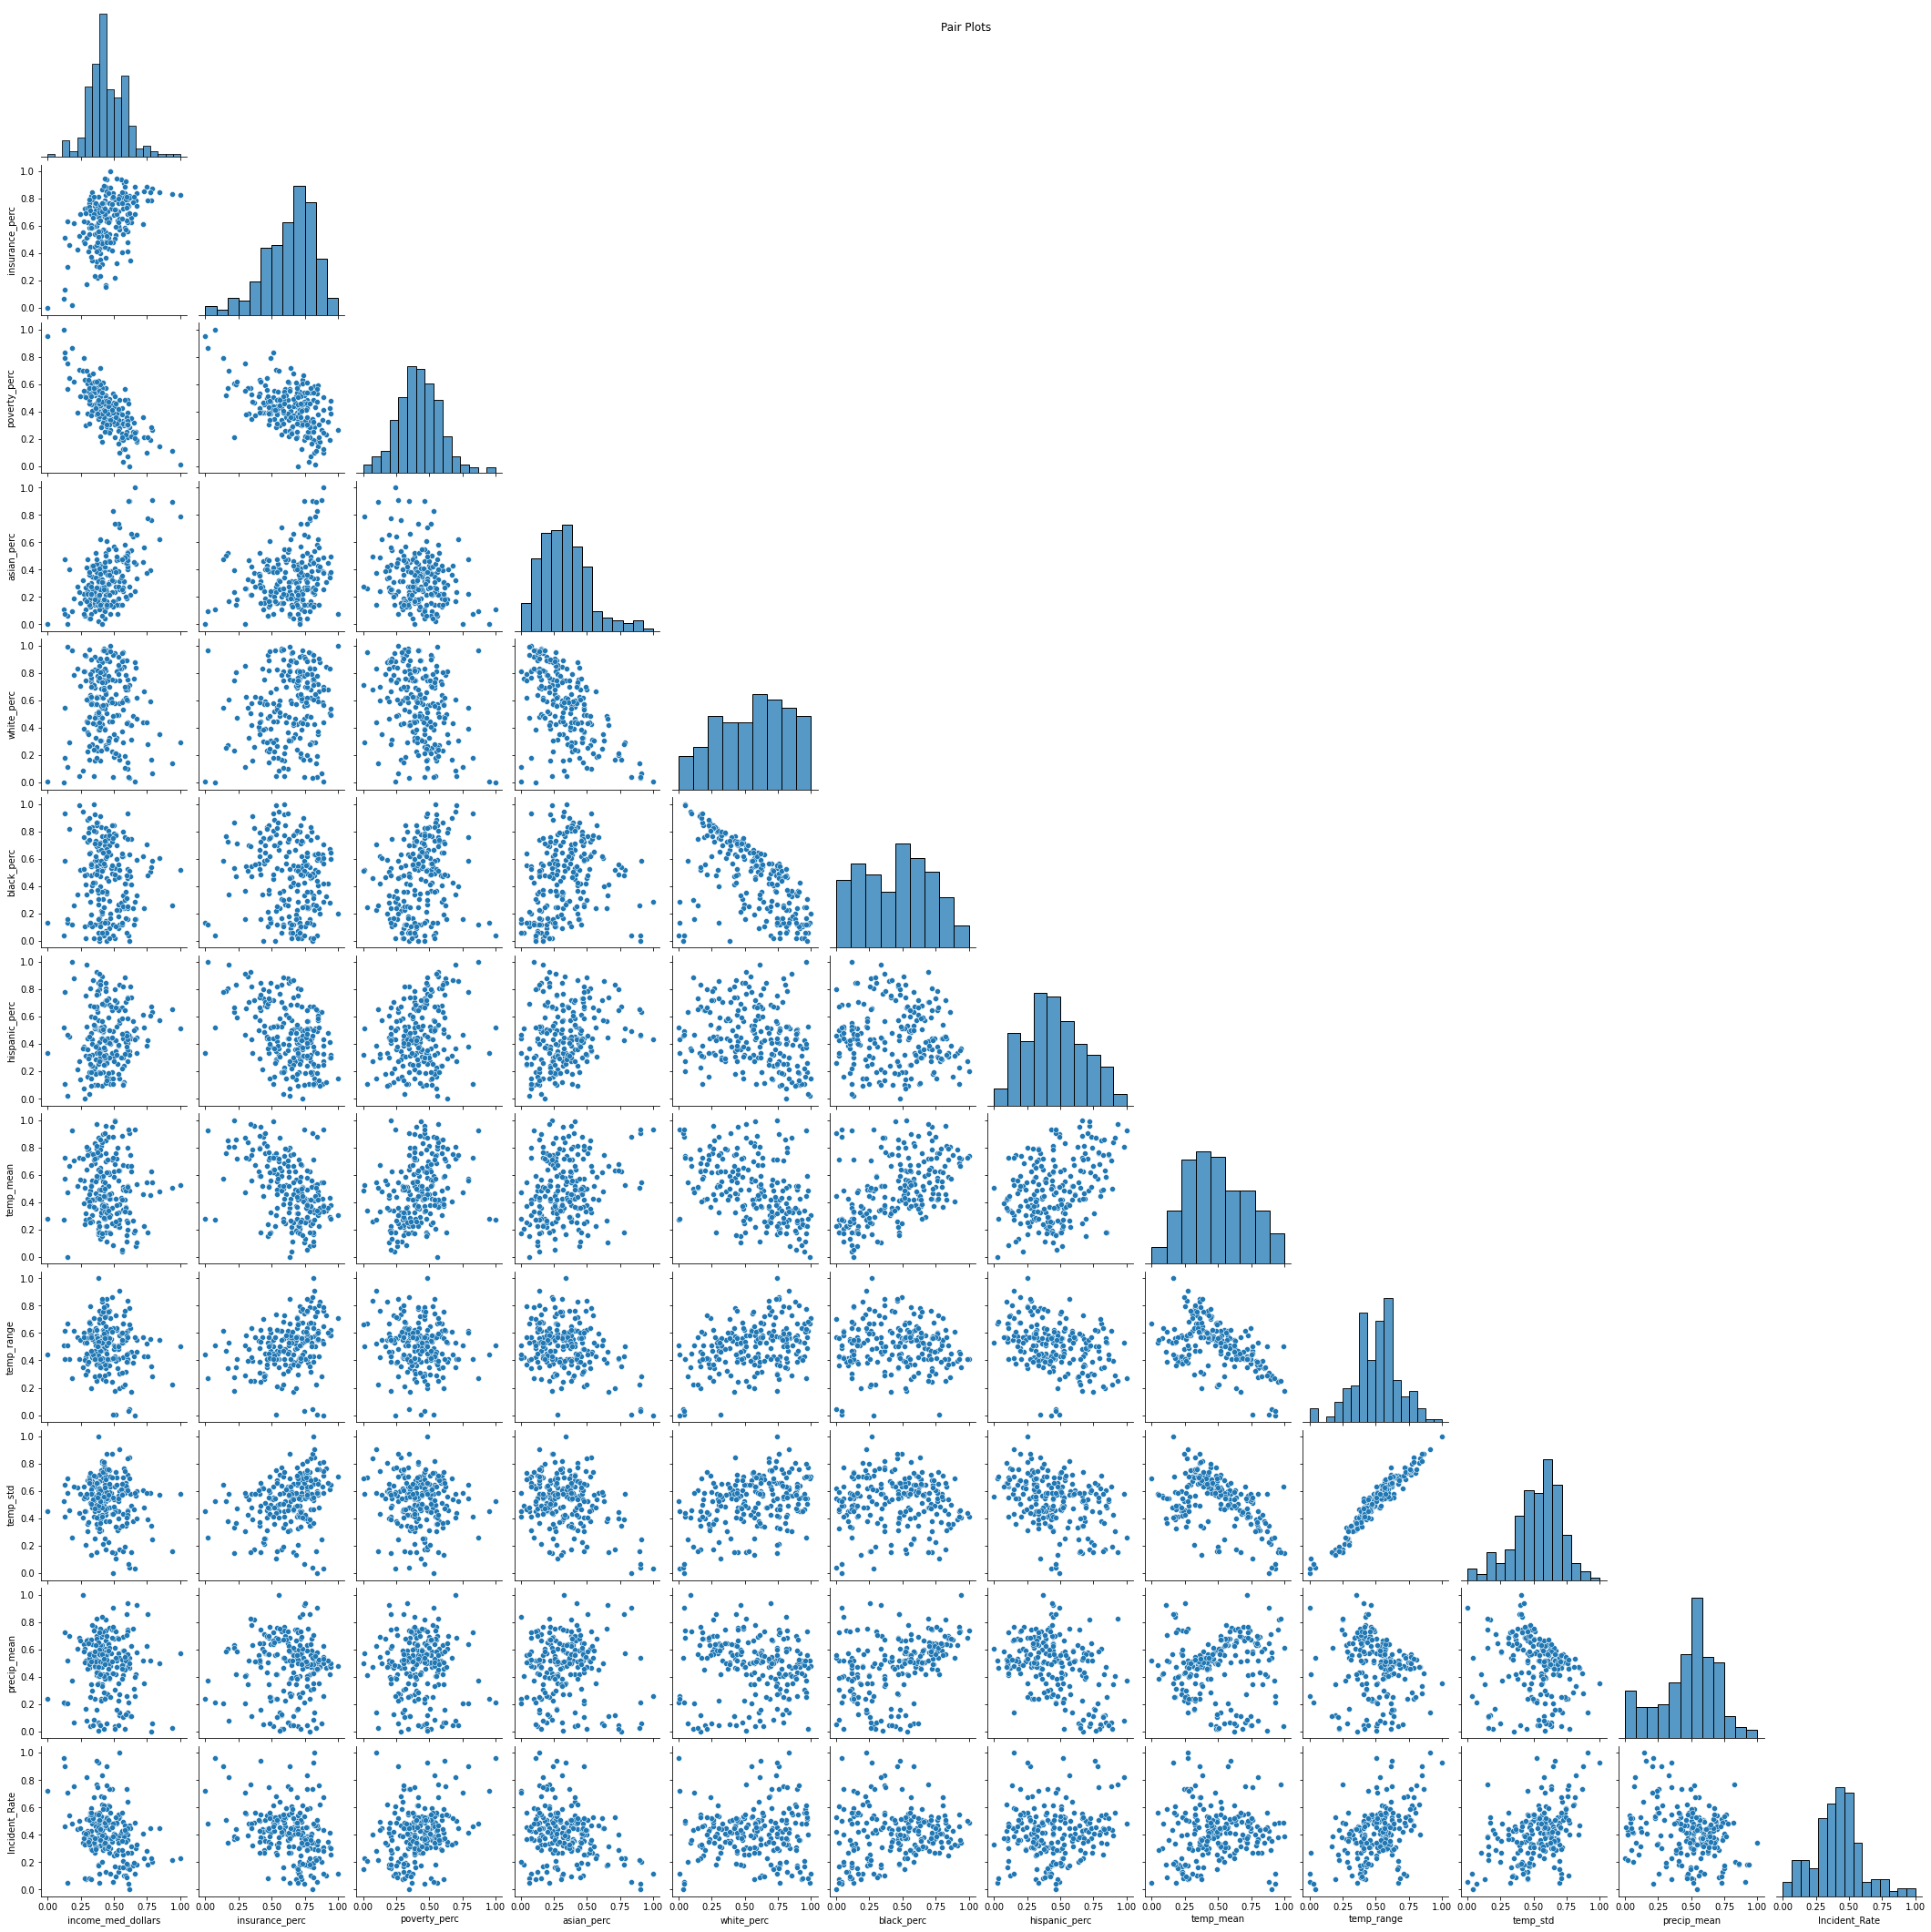

## Models Used for Inference
Since the main objective of this first analysis is to understand the importance of temperature and demographic factors as a function of the proportion of the population infected with COVID-19, we can use linear regression models. 
Linear regression allows us to easily assess the direction and weight of each feature and is more intepretable than other algorithms. In addition, our dependent variable and features are all continuous quantitative variables which can be modeled effectively through linear combinations.
We will create three linear regression models:

**1. Ordinary Least Squares (OLS)** calculated by the normal equation $\hat{\theta} = (\mathbb{X}^T\mathbb{X})^{-1} \mathbb{X}^T\mathbb{Y}$

**2. Ridge Regression** optimized by L2 regularization of the ${\theta}$ coefficients such that $\hat{\theta}_\alpha = \arg \min_\theta \left(\frac{1}{n} \sum_{i=1}^n \left(Y_i -  f_\theta(X_i)\right)^2 \right) + \alpha \sum_{k=1}^d {\theta_k}^2$

**3. Least Absolute Shrinkage and Selection Operator (Lasso)** optimized by L1 regularization of the ${\theta}$ coefficients such that $\hat{\theta}_\alpha = \arg \min_\theta \left(\frac{1}{n} \sum_{i=1}^n \left(Y_i -  f_\theta(X_i)\right)^2 \right) + \alpha \sum_{k=1}^d |\theta_k|$

### Feature Importance
Feature importance will be evaluated in two ways.

1. **Through hypothesis testing of the p-value of t-tests for each coefficient in our model.**
    - For our hypothesis test, we will set $\alpha$ = 0.05
    - For any coefficients that have a value below $\alpha$, we will reject the $H_0$ that the coefficient = 0

2. **Through observing the effect of regularization**
    - Any features that have coefficients near 0 in the ridge regression, or eliminated in the lasso regression model can be interpreted as features of lower importance. 

### Causal Inference in Observational Studies
We should always approach modeling observational studies with caution. There are many assumptions and factors we cannot control in this analysis such as . 
It is typical that in observational studies there is a lower $R^2$ than might be expected from experimental studies due to the many factors that are not measured.

In [ ]:
def olsSummaryStats(x, y):
    """
    Takes a set of features and a response variable.
    Returns summary statistics of Ordinary Least Squares.

    x - Set of features in identity matrix.
    y - Response variable to predict
    """

    ols_sig_x = sm.add_constant(x)
    ols_sig_model = sm.OLS(y, ols_sig_x)
    ols_sig_test = ols_sig_model.fit()
    return print(ols_sig_test.summary())


In [ ]:
olsSummaryStats(x = normalized_inference.drop(columns= "Incident_Rate"), y = normalized_inference["Incident_Rate"])

                            OLS Regression Results                            
Dep. Variable:          Incident_Rate   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     24.04
Date:                Thu, 14 Jan 2021   Prob (F-statistic):           1.37e-31
Time:                        01:57:20   Log-Likelihood:                 148.81
No. Observations:                 222   AIC:                            -273.6
Df Residuals:                     210   BIC:                            -232.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1887      0

### Insights

Our regression analysis indicates that we have 4 significant features

1. Percent of the Population Insured
2. Temperature Mean
3. Temperature Range
4. Precipitation

Of these, the feature with the most weight is the **temperature range**.